In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import percentileofscore

In [2]:
data = pd.read_excel("Transfer Project Data.xlsx")
newdata = pd.read_excel("Transfer Project Data 23-24.xlsx")
data = data.append(newdata)

/var/folders/_r/wmlj9j2534l1q28t983gywph0000gn/T/ipykernel_35013/3596414839.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(newdata)


In [3]:
# Calculate Win Shares per 40 (WS/40)
data['WS/40'] = 0  # Initialize all values to 0

# Update WS/40 for players with non-zero minutes played
non_zero_mp = data['MP'] != 0
data.loc[non_zero_mp, 'WS/40'] = (data.loc[non_zero_mp, 'WS'] / data.loc[non_zero_mp, 'MP']) * 40

In [4]:
# Sort the data by player and year
data.sort_values(by=['Player', 'Year'], inplace=True)

# Create a binary variable indicating whether a player transferred into the Big 12 conference in the next season
data['Transferred_to_Big12'] = ((data.groupby('Player')['Conf'].shift(-1) == 'Big 12 Conference') & (data['Conf'] != 'Big 12 Conference')).astype(int)

# Mark all subsequent seasons as transferred to the Big 12 as long as the player remains in the conference
data['Transferred_to_Big12'] = data.groupby('Player')['Transferred_to_Big12'].cumsum().clip(0, 1)

# Identify the season before the transfer to the Big 12 for each player
data['Season_Before_Transfer'] = (data['Transferred_to_Big12'] == 1) & (data.groupby('Player')['Transferred_to_Big12'].shift(1) == 0)

# Update the season before transfer to 0
data.loc[data['Season_Before_Transfer'] == True, 'Transferred_to_Big12'] = 0

# Drop the intermediate column
data.drop(columns=['Season_Before_Transfer'], inplace=True)

In [5]:
data[data['Transferred_to_Big12'] == 1]

,Player,Class,Pos,School,Conf,G,MP,tRB,tAST,tSTL,...,STLp,BLKp,PER,WS,BPM,Year,cSRS,cSOS,WS/40,Transferred_to_Big12
5226,Abayomi Iyiola,SR,F,Kansas State,Big 12 Conference,31,351,86,10,10,...,0.3,0.4,14.0,1.1,2.3,22-23,15.63,10.20,0.125356,1
6314,Adam Flagler,FR,G,Presbyterian,Big South Conference,36,1105,122,45,28,...,0.8,0.3,19.2,3.8,1.5,18-19,-6.03,-4.25,0.137557,1
650,Adam Flagler,SO,G,Baylor,Big 12 Conference,28,639,64,40,24,...,0.9,0.0,18.6,3.2,8.9,20-21,11.74,8.94,0.200313,1
742,Adam Flagler,JR,G,Baylor,Big 12 Conference,31,952,68,94,34,...,1.1,0.1,17.7,4.1,8.4,21-22,15.54,9.75,0.172269,1
914,Adam Flagler,SR,G,Baylor,Big 12 Conference,32,1081,77,147,39,...,1.2,0.1,19.6,4.6,7.8,22-23,15.63,10.20,0.170213,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,Xavier Cork,SR,F,TCU,Big 12 Conference,31,399,77,21,5,...,0.2,0.4,15.6,1.2,2.7,23-24,16.07,9.32,0.120301,1
16779,Yaya Keita,FR,F,Missouri,Southeastern Conference,21,143,26,2,7,...,0.3,0.1,6.1,0.1,-4.1,21-22,12.34,8.45,0.027972,1
23593,Yaya Keita,SO,F,Oklahoma,Big 12 Conference,2,3,0,0,0,...,0.0,0.0,-11.6,0.0,-14.9,22-23,15.63,10.20,0.000000,1
82,Yaya Keita,SO,F,Oklahoma,Big 12 Conference,10,24,10,1,0,...,0.0,0.0,15.0,0.1,-6.7,23-24,16.07,9.32,0.166667,1


In [6]:
data[data['Player'] == 'Adam Flagler']

,Player,Class,Pos,School,Conf,G,MP,tRB,tAST,tSTL,...,STLp,BLKp,PER,WS,BPM,Year,cSRS,cSOS,WS/40,Transferred_to_Big12
6314,Adam Flagler,FR,G,Presbyterian,Big South Conference,36,1105,122,45,28,...,0.8,0.3,19.2,3.8,1.5,18-19,-6.03,-4.25,0.137557,1
650,Adam Flagler,SO,G,Baylor,Big 12 Conference,28,639,64,40,24,...,0.9,0.0,18.6,3.2,8.9,20-21,11.74,8.94,0.200313,1
742,Adam Flagler,JR,G,Baylor,Big 12 Conference,31,952,68,94,34,...,1.1,0.1,17.7,4.1,8.4,21-22,15.54,9.75,0.172269,1
914,Adam Flagler,SR,G,Baylor,Big 12 Conference,32,1081,77,147,39,...,1.2,0.1,19.6,4.6,7.8,22-23,15.63,10.20,0.170213,1


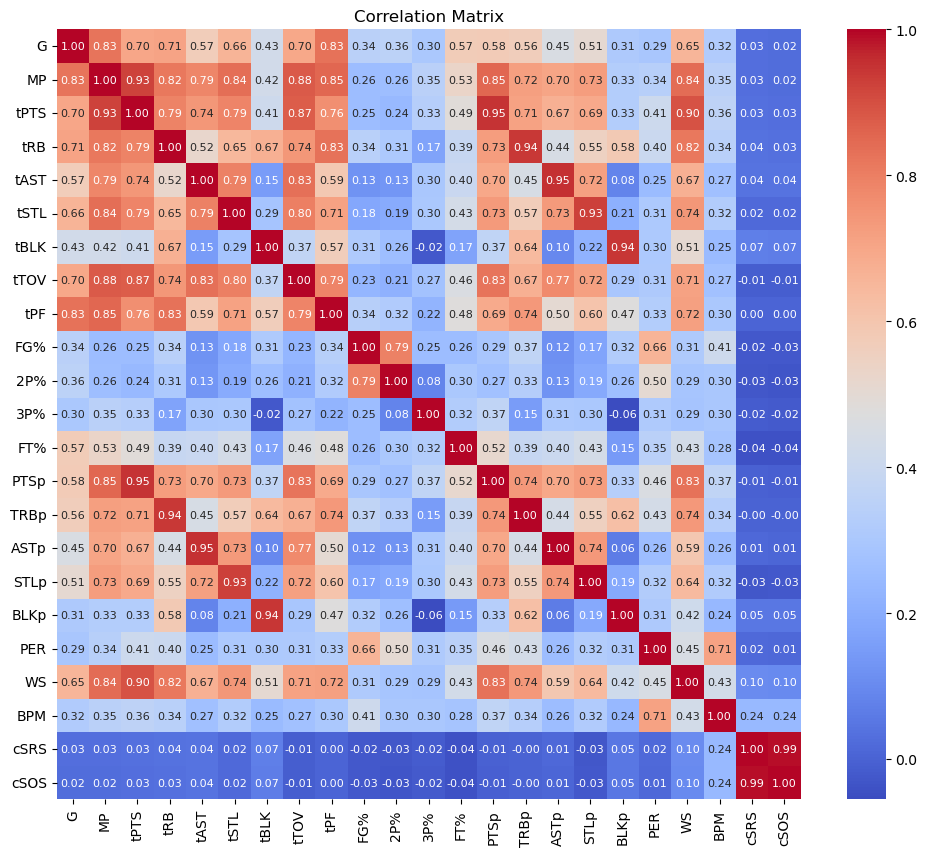

In [7]:
# Correlation analysis
selected_columns = ['G', 'MP', 'tPTS', 'tRB', 'tAST', 'tSTL', 'tBLK', 'tTOV', 'tPF', 'FG%', '2P%', '3P%', 'FT%', 'PTSp', 'TRBp', 'ASTp', 'STLp', 'BLKp', 'PER', 'WS', 'BPM', 'cSRS', 'cSOS']
correlation_matrix = data[selected_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
plt.title('Correlation Matrix')
plt.show()

In [8]:
# Convert 'Class' to categorical with the correct order
data['Class'] = pd.Categorical(data['Class'], categories=['FR', 'SO', 'JR', 'SR'], ordered=True)

# Encode 'Class' with numerical values (1 for freshman, 2 for sophomore, etc.)
data['Class_encoded'] = data['Class'].cat.codes + 1  # Adding 1 to start from 1 instead of 0

# Print the first few rows to verify the encoding
data[['Player', 'Class', 'Class_encoded']].head()

,Player,Class,Class_encoded
17006,A'Jahni Levias,FR,1
20803,A'lahn Sumler,FR,1
2970,A'lahn Sumler,SO,2
9293,A.C. Kelly,FR,1
11918,A.J. Banks,JR,3


In [9]:
# Calculate the average cSOS for the Big 12 conference over the five seasons
average_big12_csos = data[data['Conf'] == 'Big 12 Conference']['cSOS'].mean()

# Normalize cSOS values relative to the average Big 12 cSOS
data['Normalized_cSOS'] = data['cSOS'] / average_big12_csos

# Print the first few rows to verify the normalized cSOS values
data.head()

,Player,Class,Pos,School,Conf,G,MP,tRB,tAST,tSTL,...,PER,WS,BPM,Year,cSRS,cSOS,WS/40,Transferred_to_Big12,Class_encoded,Normalized_cSOS
17006,A'Jahni Levias,FR,F,North Dakota,Summit League,24,299,50,17,10,...,12.1,0.4,-4.3,22-23,-5.61,-3.38,0.053512,0,1,-0.346381
20803,A'lahn Sumler,FR,G,Northern Kentucky,Horizon League,28,281,26,11,8,...,7.4,0.3,-7.4,22-23,-6.42,-4.49,0.042705,0,1,-0.460133
2970,A'lahn Sumler,SO,G,Charleston Southern,Big South Conference,29,866,90,48,27,...,15.2,1.7,0.4,23-24,-4.38,-3.23,0.078522,0,2,-0.331009
9293,A.C. Kelly,FR,G,South Alabama,Sun Belt Conference,4,7,1,0,0,...,-28.3,-0.1,0.0,19-20,-0.78,-0.34,-0.571429,0,1,-0.034843
11918,A.J. Banks,JR,G,Wyoming,Mountain West Conference,32,761,92,49,30,...,10.8,1.0,-1.4,18-19,1.49,1.12,0.052562,0,3,0.114777


In [10]:
# Step 1: Filter Data for Players who Transferred to Big 12
transferred_to_big12_players = data[data['Transferred_to_Big12'] == 1]['Player'].unique()

# Filter Data for Players who Transferred to Big 12
before_big12 = data[(data['Player'].isin(transferred_to_big12_players)) & (data['Transferred_to_Big12'] == 0)].copy()
after_big12 = data[data['Transferred_to_Big12'] == 1].copy()

# Step 2: Calculate Overall Changes in Metrics (PER, BPM, WS/40)
overall_changes = after_big12.mean() - before_big12.mean()

# Step 3: Display Average Changes
print("Average Changes in Metrics for Players who Transferred to Big 12:")
for metric, change in overall_changes.items():
    print(f"{metric}: {change:.2f}")


Average Changes in Metrics for Players who Transferred to Big 12:
G: 0.37
MP: -31.20
tRB: -9.57
tAST: -1.47
tSTL: 0.19
tBLK: -2.48
tTOV: -4.42
tPF: -2.36
tPTS: -21.20
FG%: -0.00
2P%: -0.01
3P%: 0.00
FT%: -0.02
PTSp: -1.03
TRBp: -0.42
ASTp: -0.10
STLp: -0.03
BLKp: -0.09
PER: -1.00
WS: -0.08
BPM: 1.43
cSRS: 8.51
cSOS: 4.91
WS/40: 0.00
Transferred_to_Big12: 1.00
Class_encoded: 0.94
Normalized_cSOS: 0.50


/var/folders/_r/wmlj9j2534l1q28t983gywph0000gn/T/ipykernel_35013/1032099240.py:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  overall_changes = after_big12.mean() - before_big12.mean()
/var/folders/_r/wmlj9j2534l1q28t983gywph0000gn/T/ipykernel_35013/1032099240.py:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  overall_changes = after_big12.mean() - before_big12.mean()


In [11]:
data.head()

,Player,Class,Pos,School,Conf,G,MP,tRB,tAST,tSTL,...,PER,WS,BPM,Year,cSRS,cSOS,WS/40,Transferred_to_Big12,Class_encoded,Normalized_cSOS
17006,A'Jahni Levias,FR,F,North Dakota,Summit League,24,299,50,17,10,...,12.1,0.4,-4.3,22-23,-5.61,-3.38,0.053512,0,1,-0.346381
20803,A'lahn Sumler,FR,G,Northern Kentucky,Horizon League,28,281,26,11,8,...,7.4,0.3,-7.4,22-23,-6.42,-4.49,0.042705,0,1,-0.460133
2970,A'lahn Sumler,SO,G,Charleston Southern,Big South Conference,29,866,90,48,27,...,15.2,1.7,0.4,23-24,-4.38,-3.23,0.078522,0,2,-0.331009
9293,A.C. Kelly,FR,G,South Alabama,Sun Belt Conference,4,7,1,0,0,...,-28.3,-0.1,0.0,19-20,-0.78,-0.34,-0.571429,0,1,-0.034843
11918,A.J. Banks,JR,G,Wyoming,Mountain West Conference,32,761,92,49,30,...,10.8,1.0,-1.4,18-19,1.49,1.12,0.052562,0,3,0.114777


In [12]:
data.columns

Index(['Player', 'Class', 'Pos', 'School', 'Conf', 'G', 'MP', 'tRB', 'tAST',
       'tSTL', 'tBLK', 'tTOV', 'tPF', 'tPTS', 'FG%', '2P%', '3P%', 'FT%',
       'PTSp', 'TRBp', 'ASTp', 'STLp', 'BLKp', 'PER', 'WS', 'BPM', 'Year',
       'cSRS', 'cSOS', 'WS/40', 'Transferred_to_Big12', 'Class_encoded',
       'Normalized_cSOS'],
      dtype='object')

In [13]:
# Define numeric and categorical features
numeric_features = ['G', 'MP', 'tRB', 'tAST', 'tSTL', 'tBLK', 'tTOV', 'tPF', 'tPTS', 'FG%', '2P%', '3P%', 'FT%',
                    'PTSp', 'TRBp', 'ASTp', 'STLp', 'BLKp', 'WS', 'cSRS', 'cSOS', 'Normalized_cSOS']
categorical_features = ['Conf', 'Year', 'Transferred_to_Big12', 'Class_encoded']

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('categorical', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features)
    ])

In [15]:
# Define the features and target variables
features = ['Conf', 'Year', 'G', 'MP', 'tRB', 'tAST', 'tSTL', 'tBLK', 'tTOV', 'tPF', 'tPTS', 'FG%', '2P%', '3P%', 'FT%', 'PTSp', 'TRBp', 'ASTp', 'STLp', 'BLKp', 'WS', 'cSRS', 'cSOS', 'Transferred_to_Big12', 'Class_encoded', 'Normalized_cSOS']
target_per = 'PER'
target_bpm = 'BPM'
target_ws40 = 'WS/40'

# Split the combined dataset into training (18-23) and testing (23-24) based on year
train_data = data[data['Year'].isin(['18-19', '19-20', '20-21', '21-22', '22-23'])]
test_data = data[data['Year'] == '23-24']

# Separate features and target variables for training and testing
X_train = train_data[features]
X_test = test_data[features]

# Separate target variables for training and testing
y_train_per = train_data[target_per]
y_train_bpm = train_data[target_bpm]
y_train_ws40 = train_data[target_ws40]

y_test_per = test_data[target_per]
y_test_bpm = test_data[target_bpm]
y_test_ws40 = test_data[target_ws40]

# Preprocess the training and testing data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [211]:
# Define models
models = {
    'ElasticNet': ElasticNet(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor()
}

# Evaluate models using cross-validation
for name, model in models.items():
    scores = cross_val_score(model, X_train_processed, y_train_per, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print(f'{name} RMSE: {np.mean(rmse_scores)} +/- {np.std(rmse_scores)}')

ElasticNet RMSE: 7.720514029375259 +/- 0.4205712597208829
Ridge RMSE: 7.00656921990458 +/- 0.3189674683185937
Lasso RMSE: 7.519095540405891 +/- 0.36981211385179447
RandomForest RMSE: 4.24318689292968 +/- 0.3499907720420818
GradientBoosting RMSE: 4.508706280885635 +/- 0.28019493294277265


In [212]:
# Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Initialize Gradient Boosting regressor
gb = GradientBoostingRegressor(random_state=42)

# Perform Randomized Search for Gradient Boosting
random_search_gb = RandomizedSearchCV(estimator=gb, param_distributions=param_grid_gb,
                                      n_iter=100, scoring='neg_mean_squared_error',
                                      cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit Randomized Search to training data
random_search_gb.fit(X_train_processed, y_train_per)

# Get best hyperparameters and best estimator for Gradient Boosting
best_params_gb = random_search_gb.best_params_
best_gb = random_search_gb.best_estimator_

# Evaluate the best Gradient Boosting model on test data
gb_rmse = np.sqrt(-random_search_gb.best_score_)
print("Best RMSE for Gradient Boosting:", gb_rmse)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END learning_rate=0.05, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s[CV] END learning_rate=0.05, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s

[CV] END learning_rate=0.05, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   9.5s
[CV] END learning_rate=0.2, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n

/Users/mattlindeman/anaconda3/envs/stat386/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
265 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
116 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mattlindeman/anaconda3/envs/stat386/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mattlindeman/anaconda3/envs/stat386/lib/python3.10/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/mattlindeman/anaconda3/envs/stat386/lib/python3.10/site-packages/sklearn/base.py"

Best RMSE for Gradient Boosting: 4.024338429936363


In [16]:
best_params_gb = random_search_gb.best_params_
print("Best hyperparameters for Gradient Boosting:", best_params_gb)

NameError: name 'random_search_gb' is not defined

In [17]:
# Create a new Gradient Boosting model with the best hyperparameters
gb_model_per = GradientBoostingRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=1,
                                         max_features='sqrt', max_depth=5, learning_rate=0.2)

# Fit the model to the training data
gb_model_per.fit(X_train_processed, y_train_per)

# Evaluate the model's performance on the test data
per_predictions_gb = gb_model_per.predict(X_test_processed)

# Compute RMSE for the predictions
rmse_gb_per = np.sqrt(mean_squared_error(y_test_per, per_predictions_gb))
print("RMSE for Gradient Boosting (PER):", rmse_gb_per)

RMSE for Gradient Boosting (PER): 3.424263684246083


In [215]:
# Define models
models = {
    'ElasticNet': ElasticNet(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor()
}

# Evaluate models using cross-validation
for name, model in models.items():
    scores = cross_val_score(model, X_train_processed, y_train_bpm, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print(f'{name} RMSE: {np.mean(rmse_scores)} +/- {np.std(rmse_scores)}')

ElasticNet RMSE: 7.109465119208845 +/- 0.5760057905452997
Ridge RMSE: 6.802333540168696 +/- 0.5006246307734811
Lasso RMSE: 7.139368163543414 +/- 0.5683459515530312
RandomForest RMSE: 5.79427285392933 +/- 0.4541480722674105
GradientBoosting RMSE: 5.783860268462741 +/- 0.44704223469781507


In [216]:
# Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Initialize Gradient Boosting regressor
gb = GradientBoostingRegressor(random_state=42)

# Perform Randomized Search for Gradient Boosting
random_search_gb = RandomizedSearchCV(estimator=gb, param_distributions=param_grid_gb,
                                      n_iter=100, scoring='neg_mean_squared_error',
                                      cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit Randomized Search to training data
random_search_gb.fit(X_train_processed, y_train_bpm)

# Get best hyperparameters and best estimator for Gradient Boosting
best_params_gb = random_search_gb.best_params_
best_gb = random_search_gb.best_estimator_

# Evaluate the best Gradient Boosting model on test data
gb_rmse = np.sqrt(-random_search_gb.best_score_)
print("Best RMSE for Gradient Boosting:", gb_rmse)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   3.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   3.2s
[CV] END learning_rate=0.1, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   3.2s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n

/Users/mattlindeman/anaconda3/envs/stat386/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
240 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
118 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mattlindeman/anaconda3/envs/stat386/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mattlindeman/anaconda3/envs/stat386/lib/python3.10/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/mattlindeman/anaconda3/envs/stat386/lib/python3.10/site-packages/sklearn/base.py"

Best RMSE for Gradient Boosting: 5.668597337265156


In [217]:
best_params_gb = random_search_gb.best_params_
print("Best hyperparameters for Gradient Boosting:", best_params_gb)

Best hyperparameters for Gradient Boosting: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.1}


In [18]:
# Create a new Gradient Boosting model with the best hyperparameters
gb_model_bpm = GradientBoostingRegressor(n_estimators=400, learning_rate=0.1,
                                         max_depth=5, max_features='sqrt',
                                         min_samples_leaf=1, min_samples_split=2)

# Fit the model to the training data
gb_model_bpm.fit(X_train_processed, y_train_bpm)

# Evaluate the model's performance on the test data
bpm_predictions_gb = gb_model_bpm.predict(X_test_processed)

# Compute RMSE for the predictions
rmse_gb_bpm = np.sqrt(mean_squared_error(y_test_bpm, bpm_predictions_gb))
print("RMSE for Gradient Boosting (BPM):", rmse_gb_bpm)

RMSE for Gradient Boosting (BPM): 7.245562429712113


In [219]:
# Define models
models = {
    'ElasticNet': ElasticNet(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor()
}

# Evaluate models using cross-validation
for name, model in models.items():
    scores = cross_val_score(model, X_train_processed, y_train_ws40, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print(f'{name} RMSE: {np.mean(rmse_scores)} +/- {np.std(rmse_scores)}')

ElasticNet RMSE: 0.11712185780714993 +/- 0.009964257417491672
Ridge RMSE: 0.09187190064876331 +/- 0.011361446352843866
Lasso RMSE: 0.11712185780714993 +/- 0.009964257417491672
RandomForest RMSE: 0.007780165928408718 +/- 0.00417716896631273
GradientBoosting RMSE: 0.022442830349361557 +/- 0.0031028298225615164


In [19]:
# Create a new Random Forest model with the best hyperparameters
rf_model_ws40 = RandomForestRegressor()

# Fit the model to the training data
rf_model_ws40.fit(X_train_processed, y_train_ws40)

# Evaluate the model's performance on the test data
ws40_predictions_rf = rf_model_ws40.predict(X_test_processed)

# Compute RMSE for the predictions
rmse_rf_ws40 = np.sqrt(mean_squared_error(y_test_ws40, ws40_predictions_rf))
print("RMSE for Random Forest (WS/40):", rmse_rf_ws40)


RMSE for Random Forest (WS/40): 0.00587519075384828


In [20]:
data_2324 = data[data['Year'] == '23-24']

# Conditionally update 'Transferred_to_Big12' only for players not in the Big 12
data_2324.loc[data_2324['Conf'] != 'Big 12 Conference', 'Transferred_to_Big12'] = 1

# Increment 'Class_encoded' for all players
data_2324['Class_encoded'] = data_2324['Class_encoded'].apply(lambda x: min(x + 1, 4))

/var/folders/_r/wmlj9j2534l1q28t983gywph0000gn/T/ipykernel_35013/813368301.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2324['Class_encoded'] = data_2324['Class_encoded'].apply(lambda x: min(x + 1, 4))


In [21]:
# Step 1: Prepare the data for prediction
X_predict_2324 = preprocessor.transform(data_2324.drop(columns=['Player', 'Class', 'Pos', 'School', 'PER', 'BPM', 'WS/40']))

# Step 2: Make predictions using the trained models
predictions_per = gb_model_per.predict(X_predict_2324)  # Use your Gradient Boosting model for PER
predictions_bpm = gb_model_bpm.predict(X_predict_2324)  # Use your Gradient Boosting model for BPM
predictions_ws40 = rf_model_ws40.predict(X_predict_2324)  # Use your Random Forest model for WS/40

# Step 3: Add the predictions back to the data_2324 DataFrame
data_2324['Predicted_PER'] = predictions_per
data_2324['Predicted_BPM'] = predictions_bpm
data_2324['Predicted_WS40'] = predictions_ws40


/var/folders/_r/wmlj9j2534l1q28t983gywph0000gn/T/ipykernel_35013/3335625253.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2324['Predicted_PER'] = predictions_per
/var/folders/_r/wmlj9j2534l1q28t983gywph0000gn/T/ipykernel_35013/3335625253.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2324['Predicted_BPM'] = predictions_bpm
/var/folders/_r/wmlj9j2534l1q28t983gywph0000gn/T/ipykernel_35013/3335625253.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [22]:
data_2324

,Player,Class,Pos,School,Conf,G,MP,tRB,tAST,tSTL,...,Year,cSRS,cSOS,WS/40,Transferred_to_Big12,Class_encoded,Normalized_cSOS,Predicted_PER,Predicted_BPM,Predicted_WS40
2970,A'lahn Sumler,SO,G,Charleston Southern,Big South Conference,29,866,90,48,27,...,23-24,-4.38,-3.23,0.078522,1,3,-0.331009,15.179450,-1.446499,0.078925
424,A.J. Hoggard,SR,G,Michigan State,Big Ten Conference,30,851,93,149,44,...,23-24,13.50,9.00,0.145711,1,4,0.922315,17.131313,5.323615,0.145764
3965,A.J. Lopez,JR,G,Maine,America East Conference,26,544,36,17,19,...,23-24,-5.63,-4.56,0.088235,1,4,-0.467306,14.746785,-1.395490,0.088186
3715,A.J. McGinnis,JR,G,Lipscomb,Atlantic Sun Conference,32,958,72,28,15,...,23-24,-7.11,-3.95,0.087683,1,4,-0.404794,16.791273,-1.655213,0.087987
2836,A.J. Staton-McCray,JR,G,Samford,Southern Conference,28,607,134,36,47,...,23-24,-2.69,-2.49,0.177924,1,4,-0.255174,22.728298,3.190757,0.177062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4075,Zondrick Garrett,JR,F,Texas A&M-Commerce,Southland Conference,20,361,61,11,14,...,23-24,-9.59,-5.63,0.110803,1,4,-0.576960,17.452499,-1.513831,0.110812
240,Zuby Ejiofor,SO,F,St. John's (NY),Big East Conference,31,348,101,23,13,...,23-24,12.76,9.27,0.183908,1,3,0.949985,20.745923,5.172446,0.183950
801,Zvonimir Ivisic,FR,F,Kentucky,Southeastern Conference,13,147,42,6,4,...,23-24,12.74,8.41,0.190476,1,2,0.861853,26.530651,5.969174,0.183446
864,Zyon Pullin,SR,G,Florida,Southeastern Conference,28,943,107,140,26,...,23-24,12.74,8.41,0.186638,1,4,0.861853,21.312157,8.118347,0.187693


In [23]:
# Select only the desired columns
data_2324_reduced = data_2324[['Player', 'Class', 'Pos', 'School', 'Conf', 'Predicted_PER', 'Predicted_BPM', 'Predicted_WS40']]
data_2324_reduced[data_2324_reduced['School'] == 'Brigham Young']

,Player,Class,Pos,School,Conf,Predicted_PER,Predicted_BPM,Predicted_WS40
85,Aly Khalifa,JR,F,Brigham Young,Big 12 Conference,18.285692,6.529752,0.167348
5,Atiki Ally Atiki,JR,F,Brigham Young,Big 12 Conference,16.630979,1.593766,0.126955
57,Dallin Hall,SO,G,Brigham Young,Big 12 Conference,14.807975,4.484429,0.146883
12,Dawson Baker,JR,G,Brigham Young,Big 12 Conference,25.399299,7.531316,0.199795
169,Fousseyni Traore,JR,F,Brigham Young,Big 12 Conference,26.668893,7.499639,0.217094
112,Jared McGregor,SO,G,Brigham Young,Big 12 Conference,3.780883,-8.277902,0.000000
145,Jaxson Robinson,JR,G,Brigham Young,Big 12 Conference,18.134215,5.945398,0.138064
2,Marcus Adams Jr.,FR,F,Brigham Young,Big 12 Conference,-2.974991,-16.340730,0.000000
182,Noah Waterman,SR,F,Brigham Young,Big 12 Conference,17.550624,7.400208,0.176345
148,Richie Saunders,SO,G,Brigham Young,Big 12 Conference,21.330127,8.656276,0.216230


In [24]:
# Get summary statistics for the target variables
percentiles = data_2324[['PER', 'BPM', 'WS/40']].describe(percentiles=[0.2, 0.4, 0.6, 0.8])

# Display the percentiles
print(percentiles.loc[['20%', '40%', '60%', '80%']])

      PER   BPM     WS/40
20%   7.5 -6.30  0.006892
40%  11.4 -3.10  0.070777
60%  14.5 -0.50  0.105075
80%  18.2  2.52  0.141918


In [25]:
# Define the player's metrics
player_per = 18.15  # Example PER value for the player
player_bpm = 6.68   # Example BPM value for the player
player_ws40 = 0.18  # Example WS/40 value for the player

# Calculate percentile ranks
per_percentile_rank = percentileofscore(data_2324['PER'], player_per)
bpm_percentile_rank = percentileofscore(data_2324['BPM'], player_bpm)
ws40_percentile_rank = percentileofscore(data_2324['WS/40'], player_ws40)

print("Percentile rank for PER:", per_percentile_rank)
print("Percentile rank for BPM:", bpm_percentile_rank)
print("Percentile rank for WS/40:", ws40_percentile_rank)

Percentile rank for PER: 79.9009900990099
Percentile rank for BPM: 94.37623762376238
Percentile rank for WS/40: 91.76237623762377


In [110]:
# Assuming data_2324 is your DataFrame containing player data

# Filter the DataFrame to include only players from the Big 12 conference
big12_players = data_2324[data_2324['Conf'] == 'Big 12 Conference']

# Iterate over each row (player) in the DataFrame
for index, row in data_2324.iterrows():
    # Get the player's metrics from the current row
    player_per = row['Predicted_PER']
    player_bpm = row['Predicted_BPM']
    player_ws40 = row['Predicted_WS40']
    
    # Calculate percentile ranks for each metric based on Big 12 data
    per_percentile_rank = percentileofscore(big12_players['Predicted_PER'], player_per)
    bpm_percentile_rank = percentileofscore(big12_players['Predicted_BPM'], player_bpm)
    ws40_percentile_rank = percentileofscore(big12_players['Predicted_WS40'], player_ws40)
    
    # Save the percentile ranks back to the DataFrame
    data_2324_reduced.at[index, 'PER_Percentile_Rank'] = per_percentile_rank
    data_2324_reduced.at[index, 'BPM_Percentile_Rank'] = bpm_percentile_rank
    data_2324_reduced.at[index, 'WS40_Percentile_Rank'] = ws40_percentile_rank


In [27]:
decimal_cutoff = 3  # Set the number of decimal places you want to keep
data_2324_reduced['Predicted_PER'] = data_2324_reduced['Predicted_PER'].round(decimal_cutoff)
data_2324_reduced['Predicted_BPM'] = data_2324_reduced['Predicted_BPM'].round(decimal_cutoff)
data_2324_reduced['Predicted_WS40'] = data_2324_reduced['Predicted_WS40'].round(decimal_cutoff)
data_2324_reduced['PER_Percentile_Rank'] = data_2324_reduced['PER_Percentile_Rank'].round(decimal_cutoff)
data_2324_reduced['BPM_Percentile_Rank'] = data_2324_reduced['BPM_Percentile_Rank'].round(decimal_cutoff)
data_2324_reduced['WS40_Percentile_Rank'] = data_2324_reduced['WS40_Percentile_Rank'].round(decimal_cutoff)

/var/folders/_r/wmlj9j2534l1q28t983gywph0000gn/T/ipykernel_35013/1269976142.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2324_reduced['Predicted_PER'] = data_2324_reduced['Predicted_PER'].round(decimal_cutoff)
/var/folders/_r/wmlj9j2534l1q28t983gywph0000gn/T/ipykernel_35013/1269976142.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2324_reduced['Predicted_BPM'] = data_2324_reduced['Predicted_BPM'].round(decimal_cutoff)
/var/folders/_r/wmlj9j2534l1q28t983gywph0000gn/T/ipykernel_35013/126

In [28]:
data_2324_reduced[data_2324_reduced['School'] == 'Brigham Young']

,Player,Class,Pos,School,Conf,Predicted_PER,Predicted_BPM,Predicted_WS40,PER_Percentile_Rank,BPM_Percentile_Rank,WS40_Percentile_Rank
85,Aly Khalifa,JR,F,Brigham Young,Big 12 Conference,18.286,6.530,0.167,70.984,77.202,78.238
5,Atiki Ally Atiki,JR,F,Brigham Young,Big 12 Conference,16.631,1.594,0.127,57.513,31.606,54.404
57,Dallin Hall,SO,G,Brigham Young,Big 12 Conference,14.808,4.484,0.147,47.150,57.513,66.839
12,Dawson Baker,JR,G,Brigham Young,Big 12 Conference,25.399,7.531,0.200,98.446,89.119,91.192
169,Fousseyni Traore,JR,F,Brigham Young,Big 12 Conference,26.669,7.500,0.217,98.964,88.083,95.855
112,Jared McGregor,SO,G,Brigham Young,Big 12 Conference,3.781,-8.278,0.000,12.435,8.290,10.881
145,Jaxson Robinson,JR,G,Brigham Young,Big 12 Conference,18.134,5.945,0.138,70.466,73.057,59.585
2,Marcus Adams Jr.,FR,F,Brigham Young,Big 12 Conference,-2.975,-16.341,0.000,7.254,4.145,10.881
182,Noah Waterman,SR,F,Brigham Young,Big 12 Conference,17.551,7.400,0.176,64.767,87.047,84.974
148,Richie Saunders,SO,G,Brigham Young,Big 12 Conference,21.330,8.656,0.216,88.601,94.819,95.337


In [117]:
data_2324_reduced

,Player,Class,Pos,School,Conf,Predicted_PER,Predicted_BPM,Predicted_WS40,PER_Percentile_Rank,BPM_Percentile_Rank,WS40_Percentile_Rank
2970,A'lahn Sumler,SO,G,Charleston Southern,Big South Conference,15.179,-1.446,0.079,50.259067,19.689119,31.088083
424,A.J. Hoggard,SR,G,Michigan State,Big Ten Conference,17.131,5.324,0.146,61.658031,67.357513,65.284974
3965,A.J. Lopez,JR,G,Maine,America East Conference,14.747,-1.395,0.088,46.113990,19.689119,35.233161
3715,A.J. McGinnis,JR,G,Lipscomb,Atlantic Sun Conference,16.791,-1.655,0.088,59.067358,18.652850,35.233161
2836,A.J. Staton-McCray,JR,G,Samford,Southern Conference,22.728,3.191,0.177,93.782383,48.186528,85.492228
...,...,...,...,...,...,...,...,...,...,...,...
4075,Zondrick Garrett,JR,F,Texas A&M-Commerce,Southland Conference,17.452,-1.514,0.111,64.248705,19.689119,45.077720
240,Zuby Ejiofor,SO,F,St. John's (NY),Big East Conference,20.746,5.172,0.184,87.046632,66.321244,87.564767
801,Zvonimir Ivisic,FR,F,Kentucky,Southeastern Conference,26.531,5.969,0.183,98.445596,73.056995,87.564767
864,Zyon Pullin,SR,G,Florida,Southeastern Conference,21.312,8.118,0.188,88.082902,93.264249,88.082902


In [30]:
# Specify the file path where you want to save the CSV file
file_path = '2025Predictions.csv'

# Save the DataFrame to a CSV file
data_2324_reduced.to_csv(file_path, index=False)

In [31]:
data_m = data.iloc[:, :-3]

# Get the list of column names
columns = data_m.columns.tolist()

# Reorder columns
new_columns = columns[:-5] + [columns[-1]] + columns[-5:-1]

# Reindex the DataFrame with the new column order
data_m = data_m[new_columns]

decimal_cutoff = 3  # Set the number of decimal places you want to keep
data_m['WS/40'] = data_m['WS/40'].round(decimal_cutoff)

data_m

,Player,Class,Pos,School,Conf,G,MP,tRB,tAST,tSTL,...,ASTp,STLp,BLKp,PER,WS,WS/40,BPM,Year,cSRS,cSOS
17006,A'Jahni Levias,FR,F,North Dakota,Summit League,24,299,50,17,10,...,0.7,0.4,0.0,12.1,0.4,0.054,-4.3,22-23,-5.61,-3.38
20803,A'lahn Sumler,FR,G,Northern Kentucky,Horizon League,28,281,26,11,8,...,0.4,0.3,0.0,7.4,0.3,0.043,-7.4,22-23,-6.42,-4.49
2970,A'lahn Sumler,SO,G,Charleston Southern,Big South Conference,29,866,90,48,27,...,1.7,0.9,0.3,15.2,1.7,0.079,0.4,23-24,-4.38,-3.23
9293,A.C. Kelly,FR,G,South Alabama,Sun Belt Conference,4,7,1,0,0,...,0.0,0.0,0.0,-28.3,-0.1,-0.571,0.0,19-20,-0.78,-0.34
11918,A.J. Banks,JR,G,Wyoming,Mountain West Conference,32,761,92,49,30,...,1.5,0.9,0.4,10.8,1.0,0.053,-1.4,18-19,1.49,1.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4929,Zyon Pullin,SO,G,UC Riverside,Big West Conference,27,938,150,117,22,...,4.3,0.8,0.0,19.1,4.0,0.171,2.5,21-22,-3.65,-2.45
3484,Zyon Pullin,SR,G,UC Riverside,Big West Conference,29,984,127,122,27,...,4.2,0.9,0.1,21.7,4.2,0.171,3.7,22-23,-1.98,-1.10
864,Zyon Pullin,SR,G,Florida,Southeastern Conference,28,943,107,140,26,...,5.0,0.9,0.1,20.8,4.4,0.187,6.9,23-24,12.74,8.41
13568,Zytarious Mortle,FR,G,Texas Southern,Southwest Athletic Conference,35,696,128,30,47,...,0.9,1.3,0.3,13.3,1.3,0.075,-2.3,22-23,-12.13,-6.21


In [32]:
# Specify the file path where you want to save the CSV file
file_path = 'maindata.csv'

# Save the DataFrame to a CSV file
data_m.to_csv(file_path, index=False)

In [166]:
# Create a new column 'IWP' by dividing 'WS' by 'G'
data_nil = data_m
data_nil['IWP'] = data_nil['WS'] / data_nil['G']

In [167]:
data_nil

,Player,Class,Pos,School,Conf,G,MP,tRB,tAST,tSTL,...,STLp,BLKp,PER,WS,WS/40,BPM,Year,cSRS,cSOS,IWP
17006,A'Jahni Levias,FR,F,North Dakota,Summit League,24,299,50,17,10,...,0.4,0.0,12.1,0.4,0.054,-4.3,22-23,-5.61,-3.38,0.016667
20803,A'lahn Sumler,FR,G,Northern Kentucky,Horizon League,28,281,26,11,8,...,0.3,0.0,7.4,0.3,0.043,-7.4,22-23,-6.42,-4.49,0.010714
2970,A'lahn Sumler,SO,G,Charleston Southern,Big South Conference,29,866,90,48,27,...,0.9,0.3,15.2,1.7,0.079,0.4,23-24,-4.38,-3.23,0.058621
9293,A.C. Kelly,FR,G,South Alabama,Sun Belt Conference,4,7,1,0,0,...,0.0,0.0,-28.3,-0.1,-0.571,0.0,19-20,-0.78,-0.34,-0.025000
11918,A.J. Banks,JR,G,Wyoming,Mountain West Conference,32,761,92,49,30,...,0.9,0.4,10.8,1.0,0.053,-1.4,18-19,1.49,1.12,0.031250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4929,Zyon Pullin,SO,G,UC Riverside,Big West Conference,27,938,150,117,22,...,0.8,0.0,19.1,4.0,0.171,2.5,21-22,-3.65,-2.45,0.148148
3484,Zyon Pullin,SR,G,UC Riverside,Big West Conference,29,984,127,122,27,...,0.9,0.1,21.7,4.2,0.171,3.7,22-23,-1.98,-1.10,0.144828
864,Zyon Pullin,SR,G,Florida,Southeastern Conference,28,943,107,140,26,...,0.9,0.1,20.8,4.4,0.187,6.9,23-24,12.74,8.41,0.157143
13568,Zytarious Mortle,FR,G,Texas Southern,Southwest Athletic Conference,35,696,128,30,47,...,1.3,0.3,13.3,1.3,0.075,-2.3,22-23,-12.13,-6.21,0.037143


In [168]:
# Create an empty DataFrame with the same structure and column names as data_nil
percentiles = pd.DataFrame(columns=data_nil[['PER', 'BPM', 'WS/40']].columns)

# Iterate over each player in the DataFrame
for index, row in data_nil.iterrows():
    # Get the player's metrics from the current row
    player_per = row['PER']
    player_bpm = row['BPM']
    player_ws40 = row['WS/40']
    
    # Calculate percentile ranks for each metric based on sorted Big 12 data
    per_percentile_rank = percentileofscore(sorted(big12_players['PER']), player_per)
    bpm_percentile_rank = percentileofscore(sorted(big12_players['BPM']), player_bpm)
    ws40_percentile_rank = percentileofscore(sorted(big12_players['WS/40']), player_ws40)
    
    # Save the adjusted percentile ranks back to the DataFrame
    percentiles.at[index, 'PER'] = per_percentile_rank
    percentiles.at[index, 'BPM'] = bpm_percentile_rank
    percentiles.at[index, 'WS/40'] = ws40_percentile_rank

In [163]:
for index, row in data_nil.iterrows():
    # Check if the current row corresponds to "A'lahn Sumler"
    if row['Player'] == "A'lahn Sumler":
        print("Found A'lahn Sumler at index:", index)
        print("Player data:", row)
    
    # Get the player's metrics from the current row
    player_per = row['PER']
    player_bpm = row['BPM']
    player_ws40 = row['WS/40']
    
    # Calculate percentile ranks for each metric based on Big 12 data
    per_percentile_rank = percentileofscore(big12_players['PER'], player_per)
    bpm_percentile_rank = percentileofscore(big12_players['BPM'], player_bpm)
    ws40_percentile_rank = percentileofscore(big12_players['WS/40'], player_ws40)
    
    # Save the adjusted percentile ranks back to the DataFrame
    percentiles.at[index, 'PER'] = per_percentile_rank
    percentiles.at[index, 'BPM'] = bpm_percentile_rank
    percentiles.at[index, 'WS/40'] = ws40_percentile_rank
    
    if row['Player'] == "A'lahn Sumler":
        print(per_percentile_rank)
        print(bpm_percentile_rank)
        print(ws40_percentile_rank)


Found A'lahn Sumler at index: 20803
Player data: Player                 A'lahn Sumler
Class                             FR
Pos                                G
School             Northern Kentucky
Conf                  Horizon League
G                                 28
MP                               281
tRB                               26
tAST                              11
tSTL                               8
tBLK                               0
tTOV                              18
tPF                               26
tPTS                              81
FG%                            0.363
2P%                            0.469
3P%                            0.292
FT%                            0.643
PTSp                             2.9
TRBp                             0.9
ASTp                             0.4
STLp                             0.3
BLKp                             0.0
PER                              7.4
WS                               0.3
WS/40                     

In [169]:
# Manually insert percentile values for "A'lahn Sumler" at index 2970
percentiles.at[2970, 'PER'] = 53.36787564766839
percentiles.at[2970, 'BPM'] = 30.569948186528496
percentiles.at[2970, 'WS/40'] = 31.0880829015544

In [170]:
# Rename columns in the percentiles DataFrame
percentiles = percentiles.rename(columns={'PER': 'PER_percentile', 'BPM': 'BPM_percentile', 'WS/40': 'WS40_percentile'})
percentiles

,PER_percentile,BPM_percentile,WS40_percentile
17006,39.637306,15.544041,23.834197
20803,19.689119,11.398964,22.279793
2970,53.367876,30.569948,31.088083
9293,1.554404,29.015544,1.036269
11918,29.792746,21.761658,23.834197
...,...,...,...
5097,44.559585,43.005181,42.487047
22548,19.689119,9.84456,18.65285
21168,25.388601,10.880829,10.880829
17079,19.689119,15.544041,24.870466


In [171]:
# Merge percentile ranks with the DataFrame containing IWP
data_nil = pd.concat([data_nil, percentiles], axis=1)

In [172]:
data_nil

,Player,Class,Pos,School,Conf,G,MP,tRB,tAST,tSTL,...,WS,WS/40,BPM,Year,cSRS,cSOS,IWP,PER_percentile,BPM_percentile,WS40_percentile
17006,A'Jahni Levias,FR,F,North Dakota,Summit League,24,299,50,17,10,...,0.4,0.054,-4.3,22-23,-5.61,-3.38,0.016667,39.637306,15.544041,23.834197
20803,A'lahn Sumler,FR,G,Northern Kentucky,Horizon League,28,281,26,11,8,...,0.3,0.043,-7.4,22-23,-6.42,-4.49,0.010714,19.689119,11.398964,22.279793
2970,A'lahn Sumler,SO,G,Charleston Southern,Big South Conference,29,866,90,48,27,...,1.7,0.079,0.4,23-24,-4.38,-3.23,0.058621,53.367876,30.569948,31.088083
9293,A.C. Kelly,FR,G,South Alabama,Sun Belt Conference,4,7,1,0,0,...,-0.1,-0.571,0.0,19-20,-0.78,-0.34,-0.025000,1.554404,29.015544,1.036269
11918,A.J. Banks,JR,G,Wyoming,Mountain West Conference,32,761,92,49,30,...,1.0,0.053,-1.4,18-19,1.49,1.12,0.031250,29.792746,21.761658,23.834197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4929,Zyon Pullin,SO,G,UC Riverside,Big West Conference,27,938,150,117,22,...,4.0,0.171,2.5,21-22,-3.65,-2.45,0.148148,82.38342,43.782383,81.34715
3484,Zyon Pullin,SR,G,UC Riverside,Big West Conference,29,984,127,122,27,...,4.2,0.171,3.7,22-23,-1.98,-1.10,0.144828,91.19171,53.367876,81.34715
864,Zyon Pullin,SR,G,Florida,Southeastern Conference,28,943,107,140,26,...,4.4,0.187,6.9,23-24,12.74,8.41,0.157143,89.637306,84.974093,87.046632
13568,Zytarious Mortle,FR,G,Texas Southern,Southwest Athletic Conference,35,696,128,30,47,...,1.3,0.075,-2.3,22-23,-12.13,-6.21,0.037143,45.336788,19.689119,31.088083


In [180]:
IWP_bins = list(range(0, 101, 5))
IWP_bins

[0,
 5,
 10,
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 65,
 70,
 75,
 80,
 85,
 90,
 95,
 100]

In [181]:
# Cut the data into percentile ranges based on each variable
data_nil['PER_percentile_group'] = pd.cut(data_nil['PER_percentile'], bins=IWP_bins)
data_nil['BPM_percentile_group'] = pd.cut(data_nil['BPM_percentile'], bins=IWP_bins)
data_nil['WS40_percentile_group'] = pd.cut(data_nil['WS40_percentile'], bins=IWP_bins)

In [614]:
# Filter the DataFrame to include only players who played over 100 minutes
data_filtered = data_nil[data_nil['MP'] > 100]

# Group by percentile groups and calculate the mean IWP for each variable
mean_iwp_by_per = data_filtered.groupby('PER_percentile_group')['IWP'].mean()
mean_iwp_by_bpm = data_filtered.groupby('BPM_percentile_group')['IWP'].mean()
mean_iwp_by_ws40 = data_filtered.groupby('WS40_percentile_group')['IWP'].mean()

In [615]:
# Reset the index to make it consistent
mean_iwp_by_per = mean_iwp_by_per.reset_index()
mean_iwp_by_bpm = mean_iwp_by_bpm.reset_index()
mean_iwp_by_ws40 = mean_iwp_by_ws40.reset_index()

In [616]:
mean_iwp_by_per.at[0, 'IWP'] = 0.005
mean_iwp_by_per.at[1, 'IWP'] = 0.0075
mean_iwp_by_per.at[19, 'IWP'] = 0.117
mean_iwp_by_per.loc[0:9, 'IWP'] *= 0.3
mean_iwp_by_per.loc[10:15, 'IWP'] *= 0.6

mean_iwp_by_bpm.at[0, 'IWP'] = 0.01
mean_iwp_by_bpm.at[19, 'IWP'] = 0.129
mean_iwp_by_bpm.loc[0:9, 'IWP'] *= 0.3
mean_iwp_by_bpm.loc[10:15, 'IWP'] *= 0.6

mean_iwp_by_ws40.at[1, 'IWP'] = 0.005
mean_iwp_by_ws40.at[2, 'IWP'] = 0.01
mean_iwp_by_ws40.at[19, 'IWP'] = 0.123
mean_iwp_by_ws40.loc[0:9, 'IWP'] *= 0.3
mean_iwp_by_ws40.loc[10:15, 'IWP'] *= 0.6

In [617]:
mean_iwp_by_per

,PER_percentile_group,IWP
0,"(0, 5]",0.001500
1,"(5, 10]",0.002250
2,"(10, 15]",0.003022
3,"(15, 20]",0.005269
4,"(20, 25]",0.007483
5,"(25, 30]",0.010375
6,"(30, 35]",0.012075
7,"(35, 40]",0.013308
8,"(40, 45]",0.014825
9,"(45, 50]",0.016990


In [618]:
# Create a dataframe to store the results
percentile_df = pd.DataFrame(index=range(0, 20))  # Index represents percentile ranges

In [619]:
# Add columns for mean IWP for each variable
percentile_df['Mean_IWP_PER'] = mean_iwp_by_per['IWP']
percentile_df['Mean_IWP_BPM'] = mean_iwp_by_bpm['IWP']
percentile_df['Mean_IWP_WS40'] = mean_iwp_by_ws40['IWP']

# Rename index to represent percentile ranges
percentile_df.index.name = 'Percentile Range'

In [620]:
percentile_df

,Mean_IWP_PER,Mean_IWP_BPM,Mean_IWP_WS40
Percentile Range,,,
0,0.001500,0.003000,0.000326
1,0.002250,0.004734,0.001500
2,0.003022,0.006184,0.003000
3,0.005269,0.011881,0.004450
4,0.007483,0.016185,0.008533
5,0.010375,0.019103,0.011397
6,0.012075,0.020249,0.013383
7,0.013308,0.022576,0.016001
8,0.014825,0.022830,0.017599


In [621]:
# Merge player data with mean IWP by percentile group for each variable
merged_data = data_nil.merge(mean_iwp_by_per, on='PER_percentile_group', how='left', suffixes=('_per', '_bpm'))
merged_data = merged_data.merge(mean_iwp_by_bpm, on='BPM_percentile_group', how='left', suffixes=('_bpm', '_ws40'))
merged_data = merged_data.merge(mean_iwp_by_ws40, on='WS40_percentile_group', how='left', suffixes=('_ws40', '_dummy'))

# Calculate the weighted average IWP for each player
merged_data['Weighted_IWP'] = (merged_data['IWP_dummy'] + merged_data['IWP_bpm'] + merged_data['IWP_ws40']) / 3


In [622]:
merged_data

,Player,Class,Pos,School,Conf,G,MP,tRB,tAST,tSTL,...,PER_percentile,BPM_percentile,WS40_percentile,PER_percentile_group,BPM_percentile_group,WS40_percentile_group,IWP_bpm,IWP_ws40,IWP_dummy,Weighted_IWP
0,A'Jahni Levias,FR,F,North Dakota,Summit League,24,299,50,17,10,...,39.637306,15.544041,23.834197,"(35, 40]","(15, 20]","(20, 25]",0.013308,0.011881,0.008533,0.011241
1,A'lahn Sumler,FR,G,Northern Kentucky,Horizon League,28,281,26,11,8,...,19.689119,11.398964,22.279793,"(15, 20]","(10, 15]","(20, 25]",0.005269,0.006184,0.008533,0.006662
2,A'lahn Sumler,SO,G,Charleston Southern,Big South Conference,29,866,90,48,27,...,53.367876,30.569948,31.088083,"(50, 55]","(30, 35]","(30, 35]",0.038728,0.020249,0.013383,0.024120
3,A.C. Kelly,FR,G,South Alabama,Sun Belt Conference,4,7,1,0,0,...,1.554404,29.015544,1.036269,"(0, 5]","(25, 30]","(0, 5]",0.001500,0.019103,0.000326,0.006976
4,A.J. Banks,JR,G,Wyoming,Mountain West Conference,32,761,92,49,30,...,29.792746,21.761658,23.834197,"(25, 30]","(20, 25]","(20, 25]",0.010375,0.016185,0.008533,0.011698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29832,Zyon Pullin,SO,G,UC Riverside,Big West Conference,27,938,150,117,22,...,82.38342,43.782383,81.34715,"(80, 85]","(40, 45]","(80, 85]",0.085184,0.022830,0.090956,0.066323
29833,Zyon Pullin,SR,G,UC Riverside,Big West Conference,29,984,127,122,27,...,91.19171,53.367876,81.34715,"(90, 95]","(50, 55]","(80, 85]",0.094505,0.046861,0.090956,0.077441
29834,Zyon Pullin,SR,G,Florida,Southeastern Conference,28,943,107,140,26,...,89.637306,84.974093,87.046632,"(85, 90]","(80, 85]","(85, 90]",0.090034,0.095750,0.098186,0.094657
29835,Zytarious Mortle,FR,G,Texas Southern,Southwest Athletic Conference,35,696,128,30,47,...,45.336788,19.689119,31.088083,"(45, 50]","(15, 20]","(30, 35]",0.016990,0.011881,0.013383,0.014085


In [623]:
# Calculate the range of Weighted_IWP
weighted_iwp_min = merged_data['Weighted_IWP'].min()
weighted_iwp_max = merged_data['Weighted_IWP'].max()

print("Range of Weighted_IWP:", weighted_iwp_min, "to", weighted_iwp_max)


Range of Weighted_IWP: 0.0016086359199022373 to 0.123


In [624]:
merged_data[merged_data['School'] == 'Brigham Young']

,Player,Class,Pos,School,Conf,G,MP,tRB,tAST,tSTL,...,PER_percentile,BPM_percentile,WS40_percentile,PER_percentile_group,BPM_percentile_group,WS40_percentile_group,IWP_bpm,IWP_ws40,IWP_dummy,Weighted_IWP
806,Alex Barcello,JR,G,Brigham Young,West Coast Conference,32,963,99,56,30,...,47.150259,19.430052,31.088083,"(45, 50]","(15, 20]","(30, 35]",0.016990,0.011881,0.013383,0.014085
807,Alex Barcello,SR,G,Brigham Young,West Coast Conference,27,865,127,117,26,...,96.891192,95.854922,95.854922,"(95, 100]","(95, 100]","(95, 100]",0.117000,0.129000,0.123000,0.123000
808,Alex Barcello,SR,G,Brigham Young,West Coast Conference,35,1125,132,114,33,...,45.336788,41.968912,27.46114,"(45, 50]","(40, 45]","(25, 30]",0.016990,0.022830,0.011397,0.017072
1135,Aly Khalifa,JR,F,Brigham Young,Big 12 Conference,26,522,103,108,8,...,100.0,100.0,99.481865,"(95, 100]","(95, 100]","(95, 100]",0.117000,0.129000,0.123000,0.123000
2025,Atiki Ally Atiki,FR,F,Brigham Young,West Coast Conference,32,341,94,9,1,...,50.0,27.720207,54.92228,"(45, 50]","(25, 30]","(50, 55]",0.016990,0.019103,0.042975,0.026356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29187,Wyatt Lowell,SO,F,Brigham Young,West Coast Conference,7,44,8,1,0,...,19.170984,21.761658,35.751295,"(15, 20]","(20, 25]","(35, 40]",0.005269,0.016185,0.016001,0.012485
29380,Yoeli Childs,JR,F,Brigham Young,West Coast Conference,32,1066,309,66,31,...,97.927461,62.435233,73.57513,"(95, 100]","(60, 65]","(70, 75]",0.117000,0.050700,0.053122,0.073608
29381,Yoeli Childs,SR,F,Brigham Young,West Coast Conference,19,548,171,38,14,...,99.481865,93.264249,97.409326,"(95, 100]","(90, 95]","(95, 100]",0.117000,0.105689,0.123000,0.115230
29459,Zac Seljaas,JR,G,Brigham Young,West Coast Conference,32,723,111,41,23,...,47.668394,46.891192,39.896373,"(45, 50]","(45, 50]","(35, 40]",0.016990,0.020711,0.016001,0.017901


In [652]:
nil = data_2324_reduced.copy()

In [653]:
nil['PER_percentile_group'] = pd.cut(nil['PER_Percentile_Rank'], bins=IWP_bins)
nil['BPM_percentile_group'] = pd.cut(nil['BPM_Percentile_Rank'], bins=IWP_bins)
nil['WS40_percentile_group'] = pd.cut(nil['WS40_Percentile_Rank'], bins=IWP_bins)

In [654]:
nil

,Player,Class,Pos,School,Conf,Predicted_PER,Predicted_BPM,Predicted_WS40,PER_Percentile_Rank,BPM_Percentile_Rank,WS40_Percentile_Rank,PER_percentile_group,BPM_percentile_group,WS40_percentile_group
2970,A'lahn Sumler,SO,G,Charleston Southern,Big South Conference,15.179,-1.446,0.079,50.259067,19.689119,31.088083,"(50, 55]","(15, 20]","(30, 35]"
424,A.J. Hoggard,SR,G,Michigan State,Big Ten Conference,17.131,5.324,0.146,61.658031,67.357513,65.284974,"(60, 65]","(65, 70]","(65, 70]"
3965,A.J. Lopez,JR,G,Maine,America East Conference,14.747,-1.395,0.088,46.113990,19.689119,35.233161,"(45, 50]","(15, 20]","(35, 40]"
3715,A.J. McGinnis,JR,G,Lipscomb,Atlantic Sun Conference,16.791,-1.655,0.088,59.067358,18.652850,35.233161,"(55, 60]","(15, 20]","(35, 40]"
2836,A.J. Staton-McCray,JR,G,Samford,Southern Conference,22.728,3.191,0.177,93.782383,48.186528,85.492228,"(90, 95]","(45, 50]","(85, 90]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4075,Zondrick Garrett,JR,F,Texas A&M-Commerce,Southland Conference,17.452,-1.514,0.111,64.248705,19.689119,45.077720,"(60, 65]","(15, 20]","(45, 50]"
240,Zuby Ejiofor,SO,F,St. John's (NY),Big East Conference,20.746,5.172,0.184,87.046632,66.321244,87.564767,"(85, 90]","(65, 70]","(85, 90]"
801,Zvonimir Ivisic,FR,F,Kentucky,Southeastern Conference,26.531,5.969,0.183,98.445596,73.056995,87.564767,"(95, 100]","(70, 75]","(85, 90]"
864,Zyon Pullin,SR,G,Florida,Southeastern Conference,21.312,8.118,0.188,88.082902,93.264249,88.082902,"(85, 90]","(90, 95]","(85, 90]"


In [655]:
# Merge player data with mean IWP by percentile group for each variable
nil2 = nil.merge(mean_iwp_by_per, on='PER_percentile_group', how='left', suffixes=('_per', '_per2'))
nil2 = nil2.merge(mean_iwp_by_bpm, on='BPM_percentile_group', how='left', suffixes=('_bpm', '_bpm2'))
nil2 = nil2.merge(mean_iwp_by_ws40, on='WS40_percentile_group', how='left', suffixes=('_ws40', '_ws402'))

In [656]:
nil2

,Player,Class,Pos,School,Conf,Predicted_PER,Predicted_BPM,Predicted_WS40,PER_Percentile_Rank,BPM_Percentile_Rank,WS40_Percentile_Rank,PER_percentile_group,BPM_percentile_group,WS40_percentile_group,IWP_bpm,IWP_bpm2,IWP
0,A'lahn Sumler,SO,G,Charleston Southern,Big South Conference,15.179,-1.446,0.079,50.259067,19.689119,31.088083,"(50, 55]","(15, 20]","(30, 35]",0.038728,0.011881,0.013383
1,A.J. Hoggard,SR,G,Michigan State,Big Ten Conference,17.131,5.324,0.146,61.658031,67.357513,65.284974,"(60, 65]","(65, 70]","(65, 70]",0.043551,0.049339,0.049054
2,A.J. Lopez,JR,G,Maine,America East Conference,14.747,-1.395,0.088,46.113990,19.689119,35.233161,"(45, 50]","(15, 20]","(35, 40]",0.016990,0.011881,0.016001
3,A.J. McGinnis,JR,G,Lipscomb,Atlantic Sun Conference,16.791,-1.655,0.088,59.067358,18.652850,35.233161,"(55, 60]","(15, 20]","(35, 40]",0.039707,0.011881,0.016001
4,A.J. Staton-McCray,JR,G,Samford,Southern Conference,22.728,3.191,0.177,93.782383,48.186528,85.492228,"(90, 95]","(45, 50]","(85, 90]",0.094505,0.020711,0.098186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5045,Zondrick Garrett,JR,F,Texas A&M-Commerce,Southland Conference,17.452,-1.514,0.111,64.248705,19.689119,45.077720,"(60, 65]","(15, 20]","(45, 50]",0.043551,0.011881,0.019599
5046,Zuby Ejiofor,SO,F,St. John's (NY),Big East Conference,20.746,5.172,0.184,87.046632,66.321244,87.564767,"(85, 90]","(65, 70]","(85, 90]",0.090034,0.049339,0.098186
5047,Zvonimir Ivisic,FR,F,Kentucky,Southeastern Conference,26.531,5.969,0.183,98.445596,73.056995,87.564767,"(95, 100]","(70, 75]","(85, 90]",0.117000,0.052105,0.098186
5048,Zyon Pullin,SR,G,Florida,Southeastern Conference,21.312,8.118,0.188,88.082902,93.264249,88.082902,"(85, 90]","(90, 95]","(85, 90]",0.090034,0.105689,0.098186


In [657]:
# Calculate the weighted average IWP for each player
nil2['Weighted_IWP'] = (nil2['IWP_bpm'] + nil2['IWP_bpm2'] + nil2['IWP']) / 3

In [658]:
selected_data = nil2[['Player', 'Class', 'Pos', 'School', 'Conf', 'Weighted_IWP']]

In [659]:
selected_data['Weighted_IWP'] *= 100

/var/folders/_r/wmlj9j2534l1q28t983gywph0000gn/T/ipykernel_35013/1449245735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['Weighted_IWP'] *= 100


In [660]:
def slightly_exponential_multiply(x):
    return x ** 1.356

selected_data['Weighted_IWP'] = selected_data['Weighted_IWP'].apply(slightly_exponential_multiply)

/var/folders/_r/wmlj9j2534l1q28t983gywph0000gn/T/ipykernel_35013/3660955797.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['Weighted_IWP'] = selected_data['Weighted_IWP'].apply(slightly_exponential_multiply)


In [661]:
min_weighted_iwp = selected_data['Weighted_IWP'].min()
max_weighted_iwp = selected_data['Weighted_IWP'].max()

print(f"Minimum Weighted IWP: {min_weighted_iwp}")
print(f"Maximum Weighted IWP: {max_weighted_iwp}")

Minimum Weighted IWP: 0.08393763437965913
Maximum Weighted IWP: 30.0546262171239


In [662]:
selected_data[selected_data['School'] == 'Houston']

,Player,Class,Pos,School,Conf,Weighted_IWP
838,Cedric Lath,FR,C,Houston,Big 12 Conference,0.683704
1187,Damian Dunn,JR,G,Houston,Big 12 Conference,2.129447
1629,Emanuel Sharp,SO,G,Houston,Big 12 Conference,21.731406
2034,J'Wan Roberts,SR,F,Houston,Big 12 Conference,30.054626
2065,Ja'Vier Francis,JR,F,Houston,Big 12 Conference,24.706468
2312,Jamal Shead,SR,G,Houston,Big 12 Conference,27.597542
2721,Joseph Tugler,FR,F,Houston,Big 12 Conference,12.880871
3174,LJ Cryer,SR,G,Houston,Big 12 Conference,24.636113
3707,Mylik Wilson,SR,G,Houston,Big 12 Conference,8.386493
4076,Ramon Walker Jr.,JR,G,Houston,Big 12 Conference,5.848833


In [663]:
brigham_young_data = selected_data[selected_data['School'] == 'Brigham Young']
total_weighted_iwp = brigham_young_data['Weighted_IWP'].sum()

print(f"Total Weighted IWP for Brigham Young players: {total_weighted_iwp}")


Total Weighted IWP for Brigham Young players: 164.14688179175076


In [664]:
# Save selected_data to a CSV file
selected_data.to_csv('NIL_Pred.csv', index=False)